# Pre-processing

### Import Libaries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import radians, sin, cos, sqrt, atan2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



### Load Data

In [2]:
cleanfilepath = "../data/interim/refined_data.csv"
df = pd.read_csv(cleanfilepath,index_col =0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51047 entries, 0 to 51046
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             51047 non-null  int64  
 1   Churn                  51047 non-null  int64  
 2   MonthlyRevenue         51047 non-null  float64
 3   MonthlyMinutes         51047 non-null  float64
 4   TotalRecurringCharge   51047 non-null  float64
 5   DirectorAssistedCalls  51047 non-null  float64
 6   OverageMinutes         51047 non-null  float64
 7   RoamingCalls           51047 non-null  float64
 8   CustomerCareCalls      51047 non-null  float64
 9   IncomeGroup            51047 non-null  int64  
 10  MaritalStatus          51047 non-null  object 
 11  Occupation             51047 non-null  object 
 12  CityCode               51047 non-null  object 
 13  ChildrenInHH           51047 non-null  object 
dtypes: float64(7), int64(3), object(4)
memory usage: 5.8+ 

### Customer Segmentation 

In [4]:
# Select features for clustering
features_for_clustering = ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls'
                   , 'OverageMinutes', 'RoamingCalls', 'CustomerCareCalls', 'IncomeGroup', 'MaritalStatus', 'Occupation'
                   , 'CityCode', 'ChildrenInHH']

data_for_clustering = df[features_for_clustering]

In [5]:
# One-hot encode the 'Category' column
data_encoded = pd.get_dummies(data_for_clustering, columns=data_for_clustering.select_dtypes('object').columns)

In [6]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded)

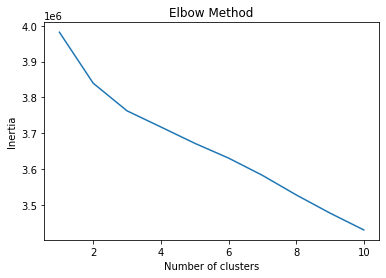

In [7]:
# Find the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the inertia to find the elbow
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



In the graph , the inertia decreases rapidly until around k=3 and then starts to decrease more slowly after that point. This suggests that the "elbow" of the plot, where the rate of decrease sharply changes, is at k=3. 

In [8]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
cluster_labels

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [9]:
df['Cluster'] = cluster_labels
churn_rate_by_cluster = df.groupby('Cluster')['Churn'].mean()
churn_count_by_cluster = df.groupby('Cluster')['Churn'].count()
Customer_count_by_cluster = df.groupby('Cluster')['CustomerID'].count()

In [10]:
churn_rate_by_cluster

Cluster
0    0.293503
1    0.286489
2    0.264366
Name: Churn, dtype: float64

In [11]:
churn_count_by_cluster

Cluster
0    28429
1    17519
2     5099
Name: Churn, dtype: int64

In [12]:
Customer_count_by_cluster

Cluster
0    28429
1    17519
2     5099
Name: CustomerID, dtype: int64

In [13]:
df

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,MaritalStatus,Occupation,CityCode,ChildrenInHH,Cluster
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,0.0,4,No,Professional,SEA,No,1
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,Yes,Professional,PIT,Yes,1
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,0.0,6,Yes,Crafts,MIL,Yes,1
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,4.3,6,No,Other,PIT,No,0
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,9,Yes,Professional,OKC,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,1,48.46,366.0,45.0,0.25,3.0,0.0,0.0,6,Yes,Other,LAX,No,0
51043,3399974,0,95.17,1745.0,85.0,0.99,45.0,4.7,0.0,9,No,Other,LAX,Yes,2
51044,3399978,1,48.46,366.0,45.0,0.25,3.0,0.0,1.3,7,No,Clerical,LAX,No,1
51045,3399990,0,48.46,366.0,45.0,0.25,3.0,0.0,0.0,9,No,Other,NEV,Yes,1


The K-Means clustering has successfully segmented the customers into three distinct clusters, with the following sizes:</br>

Cluster 0: 17509 customers</br>
Cluster 1: 28320 customers</br>
Cluster 2: 5218 customers

### Feature Engineering

<b>Encode categorical variables using one-hot encoding</b>

In [14]:
encoder = OneHotEncoder(sparse_output=False)
categorical_features = data_for_clustering.select_dtypes('object').columns
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_features

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [15]:
# Add encoded features to the dataframe

df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_feature = pd.concat([df, df_encoded], axis=1)

df_feature

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,...,CityCode_SEW,CityCode_SFR,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,0.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,0.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,4.3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,1,48.46,366.0,45.0,0.25,3.0,0.0,0.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51043,3399974,0,95.17,1745.0,85.0,0.99,45.0,4.7,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51044,3399978,1,48.46,366.0,45.0,0.25,3.0,0.0,1.3,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51045,3399990,0,48.46,366.0,45.0,0.25,3.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
# Drop the original categorical columns as they've been encoded + Customer ID 
df_feature.drop(categorical_features, axis=1, inplace=True)

df_feature

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,...,CityCode_SEW,CityCode_SFR,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,0.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,0.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,4.3,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,1,48.46,366.0,45.0,0.25,3.0,0.0,0.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51043,3399974,0,95.17,1745.0,85.0,0.99,45.0,4.7,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51044,3399978,1,48.46,366.0,45.0,0.25,3.0,0.0,1.3,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51045,3399990,0,48.46,366.0,45.0,0.25,3.0,0.0,0.0,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
# Since CustomerID is removed - remove duplicate
#if 'CustomerID' in df_feature.columns:
#    df_feature.drop('CustomerID', axis=1, inplace=True)

#df_feature.drop_duplicates(inplace=True)
#df_feature

<b>Select features for classification, including the new 'Cluster' feature</b>

In [18]:
features_for_classification = [col for col in df_feature.columns if col not in ['Churn','CustomerID']]
X = df_feature[features_for_classification]
y = df_feature['Churn']

In [19]:
X

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,Cluster,MaritalStatus_No,...,CityCode_SEW,CityCode_SFR,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes
0,24.00,219.0,22.0,0.25,0.0,0.0,0.0,4,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,38.00,8.0,38.0,0.00,0.0,0.0,0.0,6,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,82.28,1312.0,75.0,1.24,0.0,0.0,4.3,6,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,17.14,0.0,17.0,0.00,0.0,0.0,0.0,9,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,48.46,366.0,45.0,0.25,3.0,0.0,0.0,6,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51043,95.17,1745.0,85.0,0.99,45.0,4.7,0.0,9,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51044,48.46,366.0,45.0,0.25,3.0,0.0,1.3,7,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51045,48.46,366.0,45.0,0.25,3.0,0.0,0.0,9,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<b>Split the dataset into training and testing sets</b>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((40837, 79), (10210, 79), (40837,), (10210,))

Now, X_train and X_test include the cluster labels as features, and  can be train and evaluate classification models.

### Save Files for Modeling

In [22]:
##### saving as Pickle
import pickle

save_datafilepath = "../data/interim/train_test_split.pkl"
with open(save_datafilepath, 'wb') as file:
    pickle.dump([X,y,X_train, X_test, y_train, y_test], file)

In [23]:
filepath = "../data/interim/churn_cluster.csv"
df.to_csv(filepath, index=False) 